In [2]:
import rerun as rr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import scipy
%matplotlib inline

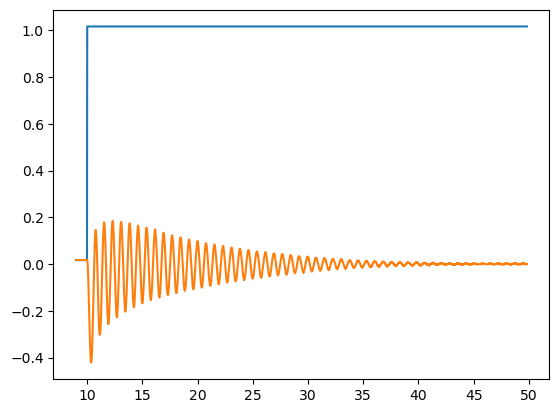

In [3]:
path_to_rrd = "./step_inv.rrd"
recording = rr.dataframe.load_recording(path_to_rrd)
batches = recording.view(index="sample_time", contents="/**").select()
df: pd.DataFrame = batches.read_pandas()

Ts = 0.01
ts = df['sample_time'].to_numpy().astype(np.float64) / 1e9
pend_angle = np.concatenate(df['/sensor_pend_angle:Scalar'].to_numpy())
control = np.concatenate(df['/control:Scalar'].to_numpy()) + 0.017
plt.plot(ts, control)
plt.plot(ts, pend_angle)

In [4]:
# Iflywheel = 827.4
# mwheel = 0.093

Iflywheel=270.4
mwheel = 0.063

est_m = 0.134
mstang = 0.038
Istang = 268.95 * mstang/est_m
rcg = 45.7
mmotor = 0.113
rout = 150 # mm
Ieverything = rcg**2*mstang + Istang + (mwheel+mmotor)*rout**2 + Iflywheel
rotratio = Iflywheel/Ieverything
rotratio

0.06165025667458976

0.147
4 states have been removed from the model
-3.831736203379345e+142


array([[ 1.003366e+00,  9.890650e-02, -2.102488e-04],
       [ 6.748703e-02,  1.001306e+00,  1.975203e-03],
       [ 3.245497e-18, -1.765374e-18,  9.858158e-01]])

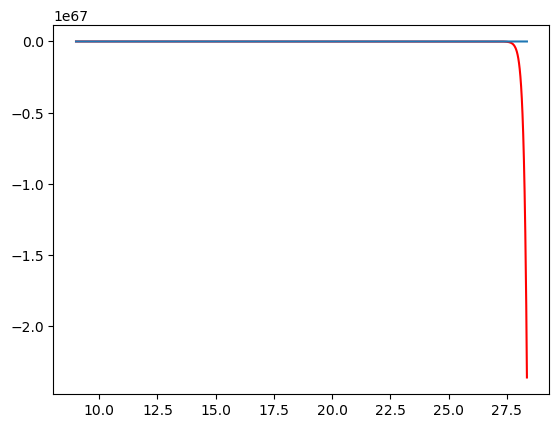

In [78]:
T = 0.7
K = 330
g = 9.81
#r = (0.150*(mwheel + mmotor) + rcg/1000 * mstang) /(mwheel + mmotor + mstang)
#r = 0.150 # real distance from axis, but the center of mass is closer to the roation axis
r = 0.147
print(r)

est_rotratio = rotratio*0.65
Gmotor = ct.tf([K], [T, 1])
RtoTheta = ct.tf([-est_rotratio,0], [1, 0.2, -g / r]) * Gmotor

deriv = ct.tf([1,0], [1])
integral = ct.tf([1], [1, 0])

ident = ct.tf([1], [1])
sys = ct.minreal(ct.interconnect(
    [ident, Gmotor, RtoTheta, RtoTheta*deriv],
    name="system",
    connections=[
        [(1, 0), (0, 0)],
        [(2, 0), (0, 0)],
        [(3, 0), (0, 0)],
    ],
    inplist=(0, 0),
    outlist=[(1, 0), (2, 0), (3, 0)],
))
sysd = ct.c2d(sys, Ts)

resp = ct.forced_response(sysd, U=control)

npoints = 2000
plt.plot(ts[:npoints], resp.y[1][:npoints], "red")
plt.plot(ts[:npoints], pend_angle[:npoints])
print(resp.y[1][-1])
sysd.A


In [79]:
G = np.array([
    [1**2, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 100000**2],
])
Qflat = np.linalg.pinv(np.kron(sysd.C, sysd.C))@G.T.reshape(9,-1)
Q = Qflat.reshape((3,3)).T
Q

R = np.array([
    [100000.0**2, 0.0, 0.0],
    [0.0, 0.0001**2, 0.01],
    [0.0, 0.0, 100000**2],
])

In [ ]:
Q1 = (
    sysd.C.T @ np.array([
        [0.00000, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 0.000]
    ]) @ sysd.C
)
Q2 = np.array([
    [10.0]
])

_, L, G = ct.dare(sysd.A, sysd.B, Q1, Q2, stabilizing=True)

In [84]:
def export_mat(mat: np.ndarray):
    mat = mat.T
    rows, cols = mat.shape
    return "[{}]".format(
        ",".join(
            "[" + ",".join("{:.6}".format(mat[row, col]) for col in range(cols)) + "]"
            for row in range(rows)
        )
    )

np.set_printoptions(precision=6)
nx = sysd.A.shape[0]
ny = sysd.C.shape[0]
rust_code = """
// THIS CODE WAS AUTOGENERATED BY `inv_pend.ipynb`
pub use crate::filter::{{LinearModel}};
pub fn pendulum_model() -> LinearModel<{}, {}> {{
    LinearModel {{
A: {}.into(),
B: {}.into(),
C: {}.into(),
D: {}.into(),
Q: {}.into(),
R: {}.into(),       
    }}
}}

pub const WHEEL_TIME_CONSTANT: f32 = {:f};
pub const WHEEL_STATIC_GAIN: f32 = {:f};
pub const INERTIA_RATIO: f32 = {:f};
pub const RADIUS: f32 = {:f};
pub const GRAVITY: f32 = 9.81;

""".format(
    nx,
    ny,
    *(export_mat(a) for a in [sysd.A, sysd.B, sysd.C, sysd.D]),
    export_mat(Q),
    export_mat(R),
    T,
    K,
    est_rotratio,
    r
)

out_path = "/home/alexander/prog/companion/common/src/model.rs"
with open(out_path, "w") as f:
    f.write(rust_code)

print(export_mat(G@np.linalg.pinv(sysd.C)))



[[-0.00582405],[-8.0924],[-0.972245]]


In [85]:
Gmotor

TransferFunction(array([330]), array([0.7, 1. ]))